In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, wait, LocalCluster
from pathlib import Path


In [2]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")

base_path = DATA_DIR/'indoor-location-navigation'

In [3]:
ssubm = pd.read_csv(base_path / 'real_timestamp_from_wifi_sample_submission.csv')

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

floor_map = {"B2":-2.0, "B1":-1.0, "F1":0.0, "F2": 1.0, "F3":2.0, "F4":3.0, "F5":4.0, "F6":5.0, "F7":6.0,"F8":7.0, "F9":8.0,
             "1F":0.0, "2F":1.0, "3F":2.0, "4F":3.0, "5F":4.0, "6F":5.0, "7F":6.0, "8F": 7.0, "9F":8.0}

In [4]:
# site_path_time_df = realtime_sample_submission_df['site_path_timestamp'].str.split('_').apply(lambda x: pd.Series(x))
ssubm_df.columns = ['site_id', 'path_id', 'waypoint_timestamp']
ssubm_df['site_path_timestamp'] = ssubm['site_path_timestamp']
ssubm_df.head(3)

,site_id,path_id,waypoint_timestamp,site_path_timestamp
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474563646,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474572654,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,1578474578963,5a0546857ecc773753327266_046cfa46be49fc1083481...


In [5]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

### site内で指定回以上登場するWiFiを抽出
100とかにしたかったが対象となるWiFiが少なすぎる。testのwaypointに紐づくWiFiの件数が少ない

In [6]:
%%time

# TODO 全体の登場回数ではなく、waypointの近くの登場回数で絞るべき
WIFI_USE_COUT = 10

bssid = dict()

for building in used_buildings:
    #break
    folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
    print(building)
    wifi = list()
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        for file in files:
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                for e, line in enumerate(txt):
                    tmp = line.strip().split()
                    if tmp[1] == "TYPE_WIFI":
                        wifi.append(tmp)
    df = pd.DataFrame(wifi)
    value_counts = df[3].value_counts()
    top_bssid = value_counts[value_counts > WIFI_USE_COUT].index.tolist() # 50回以上登場するBSSIDのみを対象にする。
    print(len(top_bssid))
    bssid[building] = top_bssid
    del df
    del wifi
    gc.collect()

5a0546857ecc773753327266
3276
5c3c44b80379370013e0fd2b
3003
5d27075f03f801723c2e360f
6750
5d27096c03f801723c31e5e0
3746
5d27097f03f801723c320d97
2368
5d27099f03f801723c32511d
885
5d2709a003f801723c3251bf
1185
5d2709b303f801723c327472
1803
5d2709bb03f801723c32852c
2337
5d2709c303f801723c3299ee
5753
5d2709d403f801723c32bd39
1959
5d2709e003f801723c32d896
1198
5da138274db8ce0c98bbd3d2
404
5da1382d4db8ce0c98bbe92e
2751
5da138314db8ce0c98bbf3a0
1127
5da138364db8ce0c98bc00f1
784
5da1383b4db8ce0c98bc11ab
1465
5da138754db8ce0c98bca82f
1478
5da138764db8ce0c98bcaa46
1767
5da1389e4db8ce0c98bd0547
841
5da138b74db8ce0c98bd4774
3454
5da958dd46f8266d0737457b
3392
5dbc1d84c1eb61796cf7c010
4413
5dc8cea7659e181adb076a3f
4443
CPU times: user 3min 32s, sys: 9.51 s, total: 3min 41s
Wall time: 3min 41s


In [7]:
# with open(f"bssid_{WIFI_USE_COUT}.json", "w") as f:
#     json.dump(bssid, f)

# with open(f"bssid_{WIFI_USE_COUT}.json") as f:
#     bssid = json.load(f)

In [8]:
%%time
def create_wifi_df(path_id):
    wifi = list()
    
    with open(os.path.join(str(base_path) + f'/test/{path_id}.txt'), encoding='utf-8') as f:
        txt = f.readlines()

    for line in txt:
        line = line.strip().split()
        if line[1] == "TYPE_WIFI":
            wifi.append(line)
            
    return pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            
wifi_base_df_counts_dfs = []
for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_base_df_counts = wifi_base_df['bssid'].value_counts().reset_index()
    wifi_base_df_counts = wifi_base_df_counts.rename(columns={'index':'bssid', 'bssid':'count'})
    wifi_base_df_counts['site_id'] = site_id
    wifi_base_df_counts_dfs.append(wifi_base_df_counts)
    
#     break

100%|██████████| 626/626 [00:29<00:00, 20.91it/s]

CPU times: user 29.4 s, sys: 609 ms, total: 30 s
Wall time: 30 s


In [9]:
wifi_base_df_counts_df = pd.concat(wifi_base_df_counts_dfs).reset_index(drop=True)
wifi_base_df_counts_df

,bssid,count,site_id
0,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,46,5da1389e4db8ce0c98bd0547
1,11567178cc5ca582a37c4733207c77739e1bf5fd,46,5da1389e4db8ce0c98bd0547
2,cfcad1ac11a3d1b8636da245e8bb42066744f3f0,46,5da1389e4db8ce0c98bd0547
3,ddf350d0ccf75a6e540a00adbc7de2a02f093fd4,46,5da1389e4db8ce0c98bd0547
4,889bfa434d66eed8c386ccbc90f445932c43f8dd,46,5da1389e4db8ce0c98bd0547
...,...,...,...
182475,46c934893439700099d03a6892ea934ecb2729d6,1,5a0546857ecc773753327266
182476,ae54f8552a572ddf81302b56c07f63c6321270be,1,5a0546857ecc773753327266
182477,16374260af7d03b10f167358a4f6a70620e131f4,1,5a0546857ecc773753327266
182478,335fe70708ab8a19936380b24cc0d53be8b88b48,1,5a0546857ecc773753327266


In [10]:
test_bssid = dict()
for building in tqdm(used_buildings):
    print(building)
    wifi_base_df_counts_df_unisite = wifi_base_df_counts_df[wifi_base_df_counts_df['site_id'] == building]
    wifi_base_df_counts_df_unisite_groupby = wifi_base_df_counts_df_unisite.groupby('bssid').sum().reset_index()
    top_bssid = wifi_base_df_counts_df_unisite_groupby[wifi_base_df_counts_df_unisite_groupby['count'] >= WIFI_USE_COUT]['bssid'].tolist()
    test_bssid[building] = top_bssid
    print(len(top_bssid))

 46%|████▌     | 11/24 [00:00<00:00, 100.25it/s]

5a0546857ecc773753327266
2310
5c3c44b80379370013e0fd2b
993
5d27075f03f801723c2e360f
988
5d27096c03f801723c31e5e0
891
5d27097f03f801723c320d97
1032
5d27099f03f801723c32511d
535
5d2709a003f801723c3251bf
816
5d2709b303f801723c327472
1123
5d2709bb03f801723c32852c
1456
5d2709c303f801723c3299ee
4106
5d2709d403f801723c32bd39
1482
5d2709e003f801723c32d896
875
5da138274db8ce0c98bbd3d2
267
5da1382d4db8ce0c98bbe92e
1737
5da138314db8ce0c98bbf3a0
879
5da138364db8ce0c98bc00f1
472
5da1383b4db8ce0c98bc11ab
1045
5da138754db8ce0c98bca82f
1015
5da138764db8ce0c98bcaa46
1157
5da1389e4db8ce0c98bd0547
372
5da138b74db8ce0c98bd4774
2258
5da958dd46f8266d0737457b


100%|██████████| 24/24 [00:00<00:00, 98.78it/s] 

2770
5dbc1d84c1eb61796cf7c010
3452
5dc8cea7659e181adb076a3f
2260


## train作成

In [11]:
%%time

TIME_DIFF_THRESHOLD = 8000 # 抽出対象とする最大時間（ミリ秒）
WIFI_NUM = 100 # WiFi抽出件数
WIFI_MIN_NUM = 10 # waypointに紐づくWiFiの最低数（この数以下の場合は学習データから除外する）
DUMMY_RECORD = [9999999999999,	'DUMMY', 'NONE', 'NONE', -999, 0, 9999999999999] # waypointに紐づくWiFi数が100件に満たない場合に穴埋めするためのダミー


train_wifi_count = []
train_wifitime_diffs = []
train_time_diffs = []
rows = []

for building in tqdm(used_buildings):
    bssids = test_bssid[building]

    for folder in sorted(glob.glob(os.path.join(base_path,'train', building +'/*'))):
        floor_str = folder.split('/')[-1]
        floor = floor_map[floor_str]
        
        for file in glob.glob(os.path.join(folder, "*.txt")):
            wifi = list()
            waypoint = list()
            
            with open(file, encoding='utf-8') as f:
                txt = f.readlines()
                
            for line in txt:
                line = line.strip().split()
                if line[1] == "TYPE_WAYPOINT":
                    waypoint.append(line)
                if line[1] == "TYPE_WIFI":
                    wifi.append(line)

            if len(wifi) <= 0:
                continue
                    
            wifi_base_df = pd.DataFrame(np.array(wifi), columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_timestamps = wifi_base_df['timestamp'].unique()
            waypoint = np.array(waypoint)
            
            
            for wifi_timestamp in wifi_timestamps:
                
                wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamp]
                
                diff = np.long(wifi_timestamp) - waypoint[:, 0].astype(np.long)
#                 diff = np.where(diff < 0, 1e16, diff)

                min_idx = np.abs(diff).argmin()
                way_time = waypoint[min_idx, 0]
                x_ = waypoint[min_idx, 2]
                y_ = waypoint[min_idx, 3]
                
                train_time_diffs.extend((wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time)).to_list())
                train_wifitime_diffs.append(np.min(diff))

                wifi_time_uni['diff_abs'] = np.abs(wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(way_time))
                wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= TIME_DIFF_THRESHOLD]
                
                train_wifi_count.append(len(wifi_time_uni))
                
                if len(wifi_time_uni) < WIFI_MIN_NUM:
                    continue
                    
                if len(wifi_time_uni) < WIFI_NUM:
                    dummy_count = WIFI_NUM - len(wifi_time_uni)
                    dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                            columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
                    wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])
                    
                wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
                
                row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                                      wifi_time_uni['bssid'].to_numpy(), 
                                      wifi_time_uni['rssi'].to_numpy(), 
                                      wifi_time_uni['frequency'].to_numpy(), 
                                      [way_time, # waypoint timestamp
                                      x_, # x
                                      y_, # y
                                      floor, # floor number
                                      floor_str, # floor string
                                      file.split('/')[-1].split('.')[0], # path_id
                                      building]
                                     ])
                rows.append(row)

                    
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  ['wp_tmestamp', 'x', 'y', 'floor', 'floor_str', 'path_id', 'site_id']
train_df = pd.DataFrame(rows, columns=columns)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 24/24 [17:05<00:00, 42.73s/it]


CPU times: user 17min 22s, sys: 7.7 s, total: 17min 30s
Wall time: 17min 30s


In [12]:
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_97,frequency_98,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,2452,2412,5745,1578469851129,157.99141,102.12539,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5745,5765,5765,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5825,5765,5745,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5180,5180,5825,1578469857653,162.93443,106.41302,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,5745,5745,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,5a0546857ecc773753327266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246855,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,0,0,1573733061352,203.53165,143.51396,6.0,F7,5dcd5c9323759900063d590a,5dc8cea7659e181adb076a3f
246856,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,0,0,1573733070079,192.5713,145.78145,6.0,F7,5dcd5c9323759900063d590a,5dc8cea7659e181adb076a3f
246857,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3

In [13]:
train_df.to_csv(DATA_DIR / 'indoorunifiedwifids_original/train_10_th8000.csv', index=False)

In [14]:
ssubm_df_diff = pd.read_csv(base_path / 'test_path_timediff.csv')

In [15]:
ssubm_df_diff[ssubm_df_diff['path_id'] == path_id]['time_diff'].values[0]

1578465315137

In [16]:
rows = []
test_wifi_count = []
test_time_diffs = []
for path_id, path_df in tqdm(ssubm_df.groupby('path_id')):
    
    site_id = path_df.iloc[0]['site_id']
    bssids = test_bssid[site_id]
    
    wifi_base_df = create_wifi_df(path_id)
    wifi_base_df = wifi_base_df[wifi_base_df['bssid'].isin(bssids)]
    
    wifi_timestamps = wifi_base_df['timestamp'].unique()
    time_diff = ssubm_df_diff[ssubm_df_diff['path_id'] == path_id]['time_diff'].values[0]
    
    for i, path_row in path_df.iterrows():
        wifi_df = wifi_base_df.copy()
        site_path_timestamp = path_row['site_path_timestamp']
        waypoint_timestamp = path_row['waypoint_timestamp']
        building = path_row['site_id']
        path_id = path_row['path_id']
        
        min_idx = np.abs(wifi_timestamps.astype(np.long) + time_diff - np.long(waypoint_timestamp)).argmin()
        
        wifi_time_uni = wifi_base_df[wifi_base_df['timestamp'] == wifi_timestamps[min_idx]]
        wifi_time_uni['diff_abs'] = np.abs(wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(waypoint_timestamp))
        test_time_diffs.extend((wifi_time_uni['last_seen_timestamp'].astype(int) - np.long(waypoint_timestamp)).to_list())

        wifi_time_uni = wifi_time_uni[wifi_time_uni['diff_abs'] <= TIME_DIFF_THRESHOLD]        

        test_wifi_count.append(len(wifi_time_uni))
        if len(wifi_time_uni) < WIFI_MIN_NUM:
            continue
        if len(wifi_time_uni) < WIFI_NUM:
            dummy_count = WIFI_NUM - len(wifi_time_uni)
            dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), 
                                    columns=['timestamp', 'data_type', 'ssid', 'bssid', 'rssi', 'frequency', 'last_seen_timestamp'])
            wifi_time_uni = pd.concat([wifi_time_uni, dummy_df])

        wifi_time_uni = wifi_time_uni.head(WIFI_NUM)
        
        row = np.concatenate([wifi_time_uni['ssid'].to_numpy(),
                              wifi_time_uni['bssid'].to_numpy(), 
                              wifi_time_uni['rssi'].to_numpy(), 
                              wifi_time_uni['frequency'].to_numpy(), 
                              [waypoint_timestamp, # waypoint timestamp
#                               x_, # x
#                               y_, # y
#                               floor, # floor number
#                               floor_str, # floor string
                              path_id, # path_id
                              building]
                             ])
        rows.append(row)
        
columns = [f'ssid_{i}' for i in range(WIFI_NUM)] + [f'bssid_{i}' for i in range(WIFI_NUM)] + [f'rssi_{i}' for i in range(WIFI_NUM)] + [f'frequency_{i}' for i in range(WIFI_NUM)] +  ['wp_tmestamp', 'path_id', 'site_id']
test_df = pd.DataFrame(rows, columns=columns)

  0%|          | 0/626 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 626/626 [01:35<00:00,  6.57it/s]


In [17]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_93,frequency_94,frequency_95,frequency_96,frequency_97,frequency_98,frequency_99,wp_tmestamp,path_id,site_id
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,0,0,0,0,0,0,0,1573190310706,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
1,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,0,0,0,0,0,0,0,1573190314744,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
2,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,f2921f9fa47c704da162c06fc348a98e83464d71,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,f2921f9fa47c704da162c06fc348a98e83464d71,fae4d5efee5c89ade8adbdf72d3e888074d22a29,...,0,0,0,0,0,0,0,1573190323222,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
3,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,0,0,0,0,0,0,0,1573190336238,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
4,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,f2921f9fa47c704da162c06fc348a98e83464d71,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,f2921f9fa47c704da162c06fc348a98e83464d71,...,0,0,0,0,0,0,0,1573190347830,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10102,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,8ece1ee8e83b5c2be32750c273a7c0b5f04f72ac,2e40049edd5106db3965286eb2446f3c14b46180,1e15285cc1ee6dd5a2700abfcd0c94d3783f41be,193453b4b2ad6268a8c6e40c0064fbf1310a6460,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,0,0,0,0,0,0,0,1578465350254,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
10103,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,193453b4b2ad6268a8c6e40c0064fbf1310a6460,8ece1ee8e83b5c2be32750c273a7c0b5f04f72ac,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,0,0,0,0,0,0,0,1578465356367,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
10104,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,193453b4b2ad6268a8c6e40c0064fbf1310a6460,d78e0816ec0328992fc6025f61304812cf54febf,6ad1c6bb0aeaa218fa705f0f8dc901c973396a9e,94c9c12f67502bf93f4ced30194b269d9cec6f92,

In [18]:
test_df['site_path_timestamp'] = test_df['site_id'] + '_' + test_df['path_id'] +'_' + test_df['wp_tmestamp']

In [19]:
test_df = test_df.sort_values('site_path_timestamp').reset_index(drop=True)

In [20]:
test_df.to_csv(DATA_DIR / 'indoorunifiedwifids_original/test_10_th8000.csv', index=False)

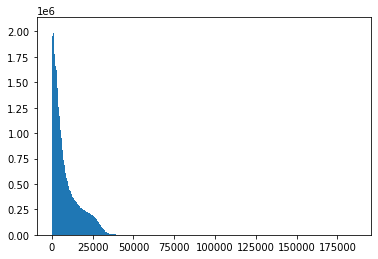

,count,mean,std,min,25%,50%,75%,max
0,46431243.0,8448.22299,8127.158008,0.0,2275.0,5425.0,12530.0,186509.0


In [15]:
plt.hist(np.abs(train_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(train_time_diffs)).describe().T

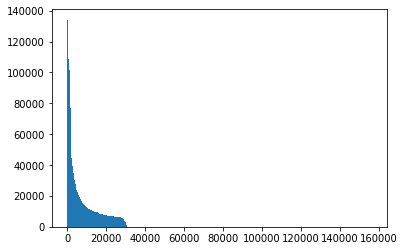

,count,mean,std,min,25%,50%,75%,max
0,1771238.0,7459.814171,8127.549076,0.0,1186.0,3808.0,11851.0,156361.0


In [44]:
plt.hist(np.abs(test_time_diffs), bins=500)
plt.show()
pd.DataFrame(np.abs(test_time_diffs)).describe().T

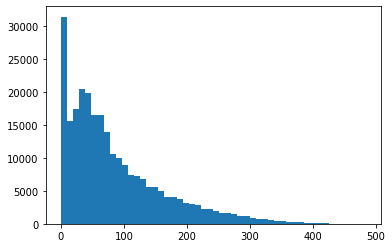

,count,mean,std,min,25%,50%,75%,max
0,258125.0,85.19532,77.339205,0.0,29.0,62.0,123.0,483.0


In [33]:
plt.hist(train_wifi_count, bins=50)
plt.show()
pd.DataFrame(train_wifi_count).describe().T

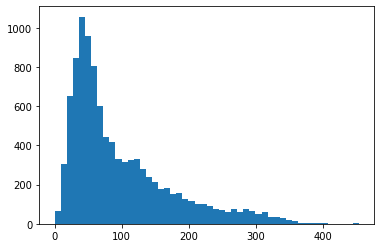

,count,mean,std,min,25%,50%,75%,max
0,10133.0,97.373631,76.165325,0.0,42.0,69.0,133.0,454.0


In [34]:
plt.hist(test_wifi_count, bins=50)
plt.show()
pd.DataFrame(test_wifi_count).describe().T

In [35]:
test_wifi_count_np = np.array(test_wifi_count)
print('WiFi10件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 10])))
print('WiFi20件以下の件数:{}'.format(len(test_wifi_count_np[test_wifi_count_np <= 20])))

WiFi10件以下の件数:82
WiFi20件以下の件数:494


In [36]:
pd.Series(test_wifi_count).value_counts().sort_index()

0      10
1       1
2       1
3       2
5       4
       ..
406     1
413     1
441     1
451     1
454     1
Length: 380, dtype: int64